In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(device.type)

# ---

torch.manual_seed(42)
np.random.seed(42)

cuda


In [9]:
t_steps = 200
num_demos = 100
num_val = 20
dx, dy = 1, 1
x = torch.linspace(0, 1, t_steps).repeat(int(num_demos/2), 1)

noise = torch.clamp(torch.randn(x.shape)*1e-4**0.5, min=0)
y0 = torch.unsqueeze(torch.sin(x*torch.pi) + noise, 2)

y1 = 1-y0

x = torch.unsqueeze(x.repeat(2,1), 2)
y = torch.cat((y0, y1), 0)
print("X:", x.shape, "Y:", y.shape)

path = "."

#######################################

vx = torch.linspace(0, 1, t_steps).repeat(int(num_val/2), 1)
vnoise = torch.clamp(torch.randn(vx.shape)*1e-4**0.5, min=0)
vy0 = torch.unsqueeze(torch.sin(vx*torch.pi) + vnoise, 2)
vy1 = 1-vy0

vx = torch.unsqueeze(vx.repeat(2,1), 2)
vy = torch.cat((vy0, vy1), 0)

X: torch.Size([100, 200, 1]) Y: torch.Size([100, 200, 1])


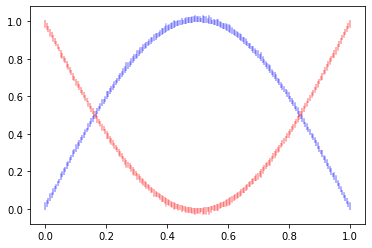

In [10]:
plt.plot(x[:50, :, 0], y[:50, :, 0], 'b', alpha=0.3)
plt.plot(x[51:, :, 0], y[51:, :, 0], 'r', alpha=0.3)
plt.show()

In [19]:
n_max = 6

def sample_training_demonstration():    
    rand_traj_ind = np.random.randint(0, num_demos)
    n = np.random.randint(1, n_max+1)

    rand_traj = y[rand_traj_ind, :, :]

    observation_indices = np.random.choice(np.arange(t_steps), n+1, replace=False) # n+1: +1 is for sampling the target
    
    observations = torch.cat((rand_traj[observation_indices[:-1], :], 
                              x[rand_traj_ind, observation_indices[:-1], :]), 1)
    targetX = torch.unsqueeze(torch.Tensor(x[rand_traj_ind, observation_indices[-1], :]), 0)
    targetY = torch.unsqueeze(torch.Tensor(rand_traj[observation_indices[-1], :]), 0)
    
    type_id = 0 if rand_traj_ind<num_demos else 1
    
    if device.type == 'cuda':
        return observations.float().cuda(), type_id, targetX.float().cuda(), targetY.float().cuda()
    else:
        return observations.float(), type_id, targetX.float(), targetY.float()


def get_validation_demonstration(ind):
    type_id = 0 if ind<num_demos else 1
    x = vx[ind, :, :]
    y = vy[ind, :, :]
    
    if device.type == 'cuda':
        return x.float().cuda(), y.float().cuda(), type_id
    else:
        return x, y, type_id

torch.Size([200, 1])
torch.Size([200, 1])


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [20]:
class BCNP(nn.Module):
    def __init__(self, in_shape):
        super(BCNP, self).__init__()
        
        dx, dy = in_shape[0], in_shape[1]
        
        dz = 128
        dzt = dz+dx
        
        self.encoder = nn.Sequential(
            nn.Linear(dx+dy, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, dz)
        )
        
        self.f0 = nn.Sequential(
            nn.Linear(dzt, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, dy*2)
        )

        self.f1 = nn.Sequential(
            nn.Linear(dzt, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, dy*2)
        )
        

    def forward(self, observations, type_id, target):
        z_out = self.encoder(observations)
        z = torch.mean(z_out, dim=0)

        zs = z.repeat(target.shape[0], 1).to(device)  # repeating the same z for each target
        z_target = torch.cat((zs, target), 1)
        
        if type_id == 0:
            return self.f0(z_target)
        else:
            return self.f1(z_target)


def log_prob_loss(ty, ty_pred):
    m, s = ty_pred.chunk(2, dim = -1)
    s = F.softplus(s)
    dist = D.Independent(D.Normal(loc=m, scale=s), 1)
    return -torch.mean(dist.log_prob(ty))


def validate():
    verr=torch.zeros(num_val)
    with torch.no_grad():
        for i in range(num_val):
            val_x, val_y, type_id = get_validation_demonstration(i)

            cond_step = 0
            observation = torch.Tensor([val_y[cond_step, :], val_x[cond_step, :]]).view(1, dx+dy)
            
            pred_traj = torch.zeros_like(val_y)
            pred_traj[cond_step, :] = val_y[cond_step, :]

            for t in range(1, t_steps):
                m, _ = model(observation, val_x[t, :])
                pred_traj[t, :] = m
                
            verr[i] = nn.MSELoss(val_y, pred_traj)
            
    return torch.mean(verr)

In [8]:
model = BCNP((1, 1))
model.to(device)

optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters(), betas=(0.9, 0.999), amsgrad=True)

val_after_iter = 2500
iters = 10000000

losses = np.zeros(int(iters/val_after_iter))
min_loss = 1e6

for i in range(iters):
    obss, type_id, tx, ty = sample_training_demonstration()
    
    optimizer.zero_grad()
    ty_preds = model(obss, type_id, tx)
    loss = log_prob_loss(ty, ty_preds)
    
    if type_id == 0:
        model.f0.requires_grad = True
        model.f1.requires_grad = False
    else:
        model.f0.requires_grad = False
        model.f1.requires_grad = True
    
    loss.backward()
    optimizer.step()
    
    if (i)%val_after_iter == 0:
        verr = validate()
        print(f"{i}: {verr}")
#     if i%val_after_iter == 0:
#         val_loss = validate()
#         print(f"{i}: {val_loss}")

#         if val_loss < min_loss:
#             min_loss = val_loss
#             torch.save(model.state_dict(), f'{path}/best_model.pt')

999: tensor(0.7745, device='cuda:0')
1999: tensor(-0.0586, device='cuda:0')
2999: tensor(0.5798, device='cuda:0')
3999: tensor(0.0238, device='cuda:0')
4999: tensor(0.3942, device='cuda:0')
5999: tensor(0.8414, device='cuda:0')
6999: tensor(-0.2993, device='cuda:0')
7999: tensor(-0.2983, device='cuda:0')
8999: tensor(0.0794, device='cuda:0')
9999: tensor(-0.3280, device='cuda:0')
10999: tensor(0.0762, device='cuda:0')
11999: tensor(-0.3878, device='cuda:0')
12999: tensor(-0.9184, device='cuda:0')
13999: tensor(-0.3770, device='cuda:0')
14999: tensor(1.5642, device='cuda:0')
15999: tensor(-1.9239, device='cuda:0')
16999: tensor(-1.2885, device='cuda:0')
17999: tensor(-1.6547, device='cuda:0')
18999: tensor(-0.4361, device='cuda:0')
19999: tensor(-0.8575, device='cuda:0')
20999: tensor(-1.9032, device='cuda:0')
21999: tensor(-2.6476, device='cuda:0')
22999: tensor(-1.4856, device='cuda:0')
23999: tensor(-0.2678, device='cuda:0')
24999: tensor(-2.7602, device='cuda:0')
25999: tensor(-2.43

203999: tensor(-3.6825, device='cuda:0')
204999: tensor(-0.3517, device='cuda:0')
205999: tensor(-3.8077, device='cuda:0')
206999: tensor(-3.3220, device='cuda:0')
207999: tensor(-2.7875, device='cuda:0')
208999: tensor(-1.9072, device='cuda:0')
209999: tensor(-3.7521, device='cuda:0')
210999: tensor(-3.3322, device='cuda:0')
211999: tensor(-3.5545, device='cuda:0')
212999: tensor(-3.1458, device='cuda:0')
213999: tensor(-3.7817, device='cuda:0')
214999: tensor(-3.7590, device='cuda:0')
215999: tensor(-3.5663, device='cuda:0')
216999: tensor(-3.7770, device='cuda:0')
217999: tensor(-2.4125, device='cuda:0')
218999: tensor(-2.1056, device='cuda:0')
219999: tensor(-3.6920, device='cuda:0')
220999: tensor(-3.7901, device='cuda:0')
221999: tensor(-1.2947, device='cuda:0')
222999: tensor(-3.4223, device='cuda:0')
223999: tensor(-3.5223, device='cuda:0')
224999: tensor(-1.4210, device='cuda:0')
225999: tensor(-3.8205, device='cuda:0')
226999: tensor(-3.5399, device='cuda:0')
227999: tensor(-

403999: tensor(-3.7264, device='cuda:0')
404999: tensor(-3.4265, device='cuda:0')
405999: tensor(-3.0732, device='cuda:0')
406999: tensor(-3.0603, device='cuda:0')
407999: tensor(-3.4513, device='cuda:0')
408999: tensor(-3.6900, device='cuda:0')
409999: tensor(-3.4685, device='cuda:0')
410999: tensor(-3.3983, device='cuda:0')
411999: tensor(-1.8442, device='cuda:0')
412999: tensor(-3.3482, device='cuda:0')
413999: tensor(-3.9125, device='cuda:0')
414999: tensor(-3.6509, device='cuda:0')
415999: tensor(-3.8912, device='cuda:0')
416999: tensor(-2.9170, device='cuda:0')
417999: tensor(-3.4850, device='cuda:0')
418999: tensor(-3.6433, device='cuda:0')
419999: tensor(-3.1352, device='cuda:0')
420999: tensor(-3.4604, device='cuda:0')
421999: tensor(-3.9352, device='cuda:0')
422999: tensor(-3.4977, device='cuda:0')
423999: tensor(-3.7058, device='cuda:0')
424999: tensor(-3.9030, device='cuda:0')
425999: tensor(-3.7477, device='cuda:0')
426999: tensor(-3.3808, device='cuda:0')
427999: tensor(-

603999: tensor(-3.6136, device='cuda:0')
604999: tensor(-3.4728, device='cuda:0')
605999: tensor(-3.5573, device='cuda:0')
606999: tensor(-3.7391, device='cuda:0')
607999: tensor(-3.6805, device='cuda:0')
608999: tensor(-2.0044, device='cuda:0')
609999: tensor(-1.4437, device='cuda:0')
610999: tensor(-3.5238, device='cuda:0')
611999: tensor(-3.6224, device='cuda:0')
612999: tensor(-3.4729, device='cuda:0')
613999: tensor(-2.8431, device='cuda:0')
614999: tensor(-3.8736, device='cuda:0')
615999: tensor(-3.9556, device='cuda:0')
616999: tensor(-3.4764, device='cuda:0')
617999: tensor(-3.8589, device='cuda:0')
618999: tensor(-3.8232, device='cuda:0')
619999: tensor(-3.6500, device='cuda:0')
620999: tensor(-2.0612, device='cuda:0')
621999: tensor(-3.9955, device='cuda:0')
622999: tensor(-3.9075, device='cuda:0')
623999: tensor(-3.7955, device='cuda:0')
624999: tensor(-3.5794, device='cuda:0')
625999: tensor(-3.6614, device='cuda:0')
626999: tensor(-3.7343, device='cuda:0')
627999: tensor(-

803999: tensor(-3.0756, device='cuda:0')
804999: tensor(-3.0071, device='cuda:0')
805999: tensor(-3.2913, device='cuda:0')
806999: tensor(-4.1172, device='cuda:0')
807999: tensor(-2.3575, device='cuda:0')
808999: tensor(-3.5720, device='cuda:0')
809999: tensor(-3.8857, device='cuda:0')
810999: tensor(-3.2684, device='cuda:0')
811999: tensor(-3.9002, device='cuda:0')
812999: tensor(-0.0969, device='cuda:0')
813999: tensor(-3.6991, device='cuda:0')
814999: tensor(-3.4405, device='cuda:0')
815999: tensor(-3.7024, device='cuda:0')
816999: tensor(-3.1824, device='cuda:0')
817999: tensor(-3.6075, device='cuda:0')
818999: tensor(-3.8463, device='cuda:0')
819999: tensor(-3.6903, device='cuda:0')
820999: tensor(-3.5345, device='cuda:0')
821999: tensor(-2.8404, device='cuda:0')
822999: tensor(-3.7113, device='cuda:0')
823999: tensor(-3.9631, device='cuda:0')
824999: tensor(-3.6087, device='cuda:0')
825999: tensor(-3.9214, device='cuda:0')
826999: tensor(-3.4812, device='cuda:0')
827999: tensor(-

1003999: tensor(-3.6227, device='cuda:0')
1004999: tensor(-3.9179, device='cuda:0')
1005999: tensor(-3.5879, device='cuda:0')
1006999: tensor(-2.1982, device='cuda:0')
1007999: tensor(-0.3753, device='cuda:0')
1008999: tensor(-3.6232, device='cuda:0')
1009999: tensor(-3.8812, device='cuda:0')
1010999: tensor(-3.7482, device='cuda:0')
1011999: tensor(-3.8483, device='cuda:0')
1012999: tensor(-3.1751, device='cuda:0')
1013999: tensor(-2.9723, device='cuda:0')
1014999: tensor(-3.7286, device='cuda:0')
1015999: tensor(-3.6464, device='cuda:0')
1016999: tensor(-3.3522, device='cuda:0')
1017999: tensor(0.9941, device='cuda:0')
1018999: tensor(-3.5924, device='cuda:0')
1019999: tensor(-2.3622, device='cuda:0')
1020999: tensor(-2.8793, device='cuda:0')
1021999: tensor(-3.4278, device='cuda:0')
1022999: tensor(-2.1873, device='cuda:0')
1023999: tensor(-3.7154, device='cuda:0')
1024999: tensor(-3.6849, device='cuda:0')
1025999: tensor(-3.7858, device='cuda:0')
1026999: tensor(-3.7145, device='cu

1199999: tensor(-3.5271, device='cuda:0')
1200999: tensor(-0.8658, device='cuda:0')
1201999: tensor(-2.4497, device='cuda:0')
1202999: tensor(-3.6089, device='cuda:0')
1203999: tensor(-3.7882, device='cuda:0')
1204999: tensor(-3.7431, device='cuda:0')
1205999: tensor(-4.0875, device='cuda:0')
1206999: tensor(-2.8668, device='cuda:0')
1207999: tensor(-3.7452, device='cuda:0')
1208999: tensor(-3.9865, device='cuda:0')
1209999: tensor(0.5059, device='cuda:0')
1210999: tensor(-3.6666, device='cuda:0')
1211999: tensor(-3.8994, device='cuda:0')
1212999: tensor(-3.6669, device='cuda:0')
1213999: tensor(-3.0269, device='cuda:0')
1214999: tensor(-3.9037, device='cuda:0')
1215999: tensor(-1.4112, device='cuda:0')
1216999: tensor(-2.8302, device='cuda:0')
1217999: tensor(-3.7586, device='cuda:0')
1218999: tensor(-3.4391, device='cuda:0')
1219999: tensor(-2.9886, device='cuda:0')
1220999: tensor(-2.4755, device='cuda:0')
1221999: tensor(-3.5929, device='cuda:0')
1222999: tensor(-2.1392, device='cu

1395999: tensor(-3.7929, device='cuda:0')
1396999: tensor(-3.4890, device='cuda:0')
1397999: tensor(-3.7983, device='cuda:0')
1398999: tensor(-2.5377, device='cuda:0')
1399999: tensor(-3.9199, device='cuda:0')
1400999: tensor(-4.0857, device='cuda:0')
1401999: tensor(-3.5163, device='cuda:0')
1402999: tensor(-1.7627, device='cuda:0')
1403999: tensor(-4.0973, device='cuda:0')
1404999: tensor(-3.7606, device='cuda:0')
1405999: tensor(-3.6324, device='cuda:0')
1406999: tensor(-3.6577, device='cuda:0')
1407999: tensor(-3.7476, device='cuda:0')
1408999: tensor(-3.6399, device='cuda:0')
1409999: tensor(-3.7510, device='cuda:0')
1410999: tensor(-3.7414, device='cuda:0')
1411999: tensor(-3.3793, device='cuda:0')
1412999: tensor(-3.0260, device='cuda:0')
1413999: tensor(-4.0163, device='cuda:0')
1414999: tensor(-3.5842, device='cuda:0')
1415999: tensor(-2.2865, device='cuda:0')
1416999: tensor(-2.8460, device='cuda:0')
1417999: tensor(-3.9643, device='cuda:0')
1418999: tensor(-3.5431, device='c

1591999: tensor(-3.7123, device='cuda:0')
1592999: tensor(-3.8399, device='cuda:0')
1593999: tensor(-3.5868, device='cuda:0')
1594999: tensor(-3.2017, device='cuda:0')
1595999: tensor(-1.9280, device='cuda:0')
1596999: tensor(-4.0484, device='cuda:0')
1597999: tensor(-3.9521, device='cuda:0')
1598999: tensor(-3.3953, device='cuda:0')
1599999: tensor(-1.7888, device='cuda:0')
1600999: tensor(-1.3842, device='cuda:0')
1601999: tensor(-3.7992, device='cuda:0')
1602999: tensor(-3.6244, device='cuda:0')
1603999: tensor(-2.0964, device='cuda:0')
1604999: tensor(-4.1002, device='cuda:0')
1605999: tensor(-3.1534, device='cuda:0')
1606999: tensor(-4.0734, device='cuda:0')
1607999: tensor(-3.6873, device='cuda:0')
1608999: tensor(-3.4420, device='cuda:0')
1609999: tensor(-3.7400, device='cuda:0')
1610999: tensor(-3.7649, device='cuda:0')
1611999: tensor(-3.6350, device='cuda:0')
1612999: tensor(-3.8294, device='cuda:0')
1613999: tensor(-1.1130, device='cuda:0')
1614999: tensor(-4.0700, device='c

1787999: tensor(-3.9552, device='cuda:0')
1788999: tensor(-3.1689, device='cuda:0')
1789999: tensor(-3.9912, device='cuda:0')
1790999: tensor(-3.6713, device='cuda:0')
1791999: tensor(-2.9609, device='cuda:0')
1792999: tensor(-2.3241, device='cuda:0')
1793999: tensor(-3.6095, device='cuda:0')
1794999: tensor(-3.8314, device='cuda:0')
1795999: tensor(-3.5440, device='cuda:0')
1796999: tensor(-3.8954, device='cuda:0')
1797999: tensor(-3.4535, device='cuda:0')
1798999: tensor(-3.8435, device='cuda:0')
1799999: tensor(-4.0568, device='cuda:0')
1800999: tensor(-3.7092, device='cuda:0')
1801999: tensor(-3.6271, device='cuda:0')
1802999: tensor(-3.8192, device='cuda:0')
1803999: tensor(-3.6775, device='cuda:0')
1804999: tensor(-3.8500, device='cuda:0')
1805999: tensor(-3.4535, device='cuda:0')
1806999: tensor(-3.8636, device='cuda:0')
1807999: tensor(-3.3337, device='cuda:0')
1808999: tensor(-3.5251, device='cuda:0')
1809999: tensor(-3.9785, device='cuda:0')
1810999: tensor(-3.1520, device='c

1983999: tensor(-3.8844, device='cuda:0')
1984999: tensor(-3.7592, device='cuda:0')
1985999: tensor(-3.7206, device='cuda:0')
1986999: tensor(-3.8815, device='cuda:0')
1987999: tensor(-3.6450, device='cuda:0')
1988999: tensor(-3.2706, device='cuda:0')
1989999: tensor(-3.6397, device='cuda:0')
1990999: tensor(-3.7594, device='cuda:0')
1991999: tensor(-4.0585, device='cuda:0')
1992999: tensor(-3.6453, device='cuda:0')
1993999: tensor(-3.4649, device='cuda:0')
1994999: tensor(-3.7432, device='cuda:0')
1995999: tensor(-3.2671, device='cuda:0')
1996999: tensor(-4.0721, device='cuda:0')
1997999: tensor(-3.3003, device='cuda:0')
1998999: tensor(-3.5300, device='cuda:0')
1999999: tensor(-3.7361, device='cuda:0')
2000999: tensor(-3.7266, device='cuda:0')
2001999: tensor(-4.0534, device='cuda:0')
2002999: tensor(-2.0033, device='cuda:0')
2003999: tensor(-3.9275, device='cuda:0')
2004999: tensor(-3.9146, device='cuda:0')
2005999: tensor(-3.5160, device='cuda:0')
2006999: tensor(-4.1309, device='c

2179999: tensor(-4.0948, device='cuda:0')
2180999: tensor(-3.7482, device='cuda:0')
2181999: tensor(-2.1497, device='cuda:0')
2182999: tensor(-3.2965, device='cuda:0')
2183999: tensor(-3.0345, device='cuda:0')
2184999: tensor(-4.1392, device='cuda:0')
2185999: tensor(-3.7684, device='cuda:0')
2186999: tensor(-3.8717, device='cuda:0')
2187999: tensor(-2.1021, device='cuda:0')
2188999: tensor(1.3289, device='cuda:0')
2189999: tensor(-2.1181, device='cuda:0')
2190999: tensor(-4.0792, device='cuda:0')
2191999: tensor(-4.0224, device='cuda:0')
2192999: tensor(-4.0740, device='cuda:0')
2193999: tensor(-3.8063, device='cuda:0')
2194999: tensor(-0.7250, device='cuda:0')
2195999: tensor(-3.9058, device='cuda:0')
2196999: tensor(-3.9335, device='cuda:0')
2197999: tensor(-3.9633, device='cuda:0')
2198999: tensor(-3.8122, device='cuda:0')
2199999: tensor(-3.6858, device='cuda:0')
2200999: tensor(-3.9447, device='cuda:0')
2201999: tensor(-3.3182, device='cuda:0')
2202999: tensor(-2.4447, device='cu

2375999: tensor(-3.7706, device='cuda:0')
2376999: tensor(-3.8576, device='cuda:0')
2377999: tensor(-3.2733, device='cuda:0')
2378999: tensor(-4.0966, device='cuda:0')
2379999: tensor(-3.8767, device='cuda:0')
2380999: tensor(-4.0558, device='cuda:0')
2381999: tensor(-3.8049, device='cuda:0')
2382999: tensor(-2.8786, device='cuda:0')
2383999: tensor(-3.8444, device='cuda:0')
2384999: tensor(-3.3021, device='cuda:0')
2385999: tensor(-3.8172, device='cuda:0')
2386999: tensor(-3.9312, device='cuda:0')
2387999: tensor(-3.3906, device='cuda:0')
2388999: tensor(-3.8203, device='cuda:0')
2389999: tensor(-2.9754, device='cuda:0')
2390999: tensor(-3.9704, device='cuda:0')
2391999: tensor(-3.3548, device='cuda:0')
2392999: tensor(-3.6671, device='cuda:0')
2393999: tensor(-3.6134, device='cuda:0')
2394999: tensor(-3.8744, device='cuda:0')
2395999: tensor(-4.0414, device='cuda:0')
2396999: tensor(-3.8908, device='cuda:0')
2397999: tensor(-3.6814, device='cuda:0')
2398999: tensor(-3.8933, device='c

2571999: tensor(-1.0082, device='cuda:0')
2572999: tensor(0.7201, device='cuda:0')
2573999: tensor(-3.1792, device='cuda:0')
2574999: tensor(-3.7807, device='cuda:0')
2575999: tensor(-3.8279, device='cuda:0')
2576999: tensor(-4.0910, device='cuda:0')
2577999: tensor(-3.2796, device='cuda:0')
2578999: tensor(-3.9953, device='cuda:0')
2579999: tensor(-0.9235, device='cuda:0')
2580999: tensor(-3.9043, device='cuda:0')
2581999: tensor(-2.9363, device='cuda:0')
2582999: tensor(-3.7864, device='cuda:0')
2583999: tensor(-3.9225, device='cuda:0')
2584999: tensor(-3.8449, device='cuda:0')
2585999: tensor(-3.8462, device='cuda:0')
2586999: tensor(-3.3064, device='cuda:0')
2587999: tensor(-3.2034, device='cuda:0')
2588999: tensor(-3.2160, device='cuda:0')
2589999: tensor(-3.7827, device='cuda:0')
2590999: tensor(-3.6110, device='cuda:0')
2591999: tensor(-3.4332, device='cuda:0')
2592999: tensor(-3.8518, device='cuda:0')
2593999: tensor(-3.3799, device='cuda:0')
2594999: tensor(-3.8275, device='cu

2767999: tensor(-3.2173, device='cuda:0')
2768999: tensor(-3.4452, device='cuda:0')
2769999: tensor(-0.1849, device='cuda:0')
2770999: tensor(-2.8548, device='cuda:0')
2771999: tensor(-3.8233, device='cuda:0')
2772999: tensor(-3.3763, device='cuda:0')
2773999: tensor(-1.7101, device='cuda:0')
2774999: tensor(-4.0301, device='cuda:0')
2775999: tensor(-3.6351, device='cuda:0')
2776999: tensor(-3.8832, device='cuda:0')
2777999: tensor(-2.4326, device='cuda:0')
2778999: tensor(-4.0038, device='cuda:0')
2779999: tensor(-3.9459, device='cuda:0')
2780999: tensor(-4.0447, device='cuda:0')
2781999: tensor(-3.8583, device='cuda:0')
2782999: tensor(-3.4016, device='cuda:0')
2783999: tensor(-4.0282, device='cuda:0')
2784999: tensor(-4.0665, device='cuda:0')
2785999: tensor(-3.5083, device='cuda:0')
2786999: tensor(-3.9041, device='cuda:0')
2787999: tensor(-3.7684, device='cuda:0')
2788999: tensor(-2.9125, device='cuda:0')
2789999: tensor(-4.0731, device='cuda:0')
2790999: tensor(-3.8484, device='c

2963999: tensor(-3.9177, device='cuda:0')
2964999: tensor(-2.3402, device='cuda:0')
2965999: tensor(-3.9749, device='cuda:0')
2966999: tensor(-3.8310, device='cuda:0')
2967999: tensor(-3.9974, device='cuda:0')
2968999: tensor(-4.1430, device='cuda:0')
2969999: tensor(-3.7618, device='cuda:0')
2970999: tensor(-3.7380, device='cuda:0')
2971999: tensor(-4.1051, device='cuda:0')
2972999: tensor(-3.7588, device='cuda:0')
2973999: tensor(-3.3647, device='cuda:0')
2974999: tensor(-3.8517, device='cuda:0')
2975999: tensor(-3.9586, device='cuda:0')
2976999: tensor(-4.0633, device='cuda:0')
2977999: tensor(-3.5522, device='cuda:0')
2978999: tensor(-4.1345, device='cuda:0')
2979999: tensor(-3.1629, device='cuda:0')
2980999: tensor(-4.0841, device='cuda:0')
2981999: tensor(-3.7438, device='cuda:0')
2982999: tensor(-3.9824, device='cuda:0')
2983999: tensor(-4.0348, device='cuda:0')
2984999: tensor(-3.9582, device='cuda:0')
2985999: tensor(-3.9426, device='cuda:0')
2986999: tensor(-3.8852, device='c

3159999: tensor(-3.7019, device='cuda:0')
3160999: tensor(-4.1498, device='cuda:0')
3161999: tensor(-3.7360, device='cuda:0')
3162999: tensor(-3.2857, device='cuda:0')
3163999: tensor(-3.8141, device='cuda:0')
3164999: tensor(-3.3466, device='cuda:0')
3165999: tensor(-3.1920, device='cuda:0')
3166999: tensor(-3.8253, device='cuda:0')
3167999: tensor(-3.8492, device='cuda:0')
3168999: tensor(-3.6967, device='cuda:0')
3169999: tensor(-2.3653, device='cuda:0')
3170999: tensor(-3.9054, device='cuda:0')
3171999: tensor(-2.8343, device='cuda:0')
3172999: tensor(-3.5915, device='cuda:0')
3173999: tensor(-3.6288, device='cuda:0')
3174999: tensor(-4.1009, device='cuda:0')
3175999: tensor(-3.9618, device='cuda:0')
3176999: tensor(-3.4838, device='cuda:0')
3177999: tensor(-3.8699, device='cuda:0')
3178999: tensor(-4.0189, device='cuda:0')
3179999: tensor(-3.8460, device='cuda:0')
3180999: tensor(0.6360, device='cuda:0')
3181999: tensor(-3.8420, device='cuda:0')
3182999: tensor(-3.7611, device='cu

3355999: tensor(-4.0764, device='cuda:0')
3356999: tensor(-4.0644, device='cuda:0')
3357999: tensor(-3.6774, device='cuda:0')
3358999: tensor(-3.7596, device='cuda:0')
3359999: tensor(-1.5304, device='cuda:0')
3360999: tensor(-3.8560, device='cuda:0')
3361999: tensor(-3.9318, device='cuda:0')
3362999: tensor(0.9432, device='cuda:0')
3363999: tensor(-2.5674, device='cuda:0')
3364999: tensor(-3.8844, device='cuda:0')
3365999: tensor(-3.8185, device='cuda:0')
3366999: tensor(-3.8186, device='cuda:0')
3367999: tensor(-3.3069, device='cuda:0')
3368999: tensor(-3.0551, device='cuda:0')
3369999: tensor(-4.0483, device='cuda:0')
3370999: tensor(-4.0694, device='cuda:0')
3371999: tensor(-3.5435, device='cuda:0')
3372999: tensor(-3.6078, device='cuda:0')
3373999: tensor(-3.9709, device='cuda:0')
3374999: tensor(-3.7967, device='cuda:0')
3375999: tensor(-4.0614, device='cuda:0')
3376999: tensor(0.0705, device='cuda:0')
3377999: tensor(-2.4500, device='cuda:0')
3378999: tensor(-4.0143, device='cud

3551999: tensor(-4.0303, device='cuda:0')
3552999: tensor(-3.6276, device='cuda:0')
3553999: tensor(-4.0955, device='cuda:0')
3554999: tensor(-1.3688, device='cuda:0')
3555999: tensor(-3.6935, device='cuda:0')
3556999: tensor(-3.8914, device='cuda:0')
3557999: tensor(-3.9025, device='cuda:0')
3558999: tensor(-3.0298, device='cuda:0')
3559999: tensor(-3.8216, device='cuda:0')
3560999: tensor(-4.0296, device='cuda:0')
3561999: tensor(-3.9381, device='cuda:0')
3562999: tensor(-3.0082, device='cuda:0')
3563999: tensor(-3.9857, device='cuda:0')
3564999: tensor(-4.1003, device='cuda:0')
3565999: tensor(-2.6588, device='cuda:0')
3566999: tensor(-3.8795, device='cuda:0')
3567999: tensor(-3.0884, device='cuda:0')
3568999: tensor(-3.2590, device='cuda:0')
3569999: tensor(-3.5816, device='cuda:0')
3570999: tensor(-4.0403, device='cuda:0')
3571999: tensor(-3.9311, device='cuda:0')
3572999: tensor(4.9437, device='cuda:0')
3573999: tensor(-3.1200, device='cuda:0')
3574999: tensor(-3.8453, device='cu

3747999: tensor(-3.8380, device='cuda:0')
3748999: tensor(-1.4466, device='cuda:0')
3749999: tensor(-3.8558, device='cuda:0')
3750999: tensor(-4.0513, device='cuda:0')
3751999: tensor(-4.1081, device='cuda:0')
3752999: tensor(-4.0544, device='cuda:0')
3753999: tensor(-4.0805, device='cuda:0')
3754999: tensor(-2.6713, device='cuda:0')
3755999: tensor(-3.8007, device='cuda:0')
3756999: tensor(-4.1126, device='cuda:0')
3757999: tensor(-3.6464, device='cuda:0')
3758999: tensor(-3.7410, device='cuda:0')
3759999: tensor(-4.0100, device='cuda:0')
3760999: tensor(-3.5833, device='cuda:0')
3761999: tensor(-3.4482, device='cuda:0')
3762999: tensor(-3.5998, device='cuda:0')
3763999: tensor(-3.7345, device='cuda:0')
3764999: tensor(-2.7982, device='cuda:0')
3765999: tensor(-3.2273, device='cuda:0')
3766999: tensor(-3.8132, device='cuda:0')
3767999: tensor(-4.0164, device='cuda:0')
3768999: tensor(-4.0978, device='cuda:0')
3769999: tensor(-4.0315, device='cuda:0')
3770999: tensor(-3.8140, device='c

3943999: tensor(-4.0044, device='cuda:0')
3944999: tensor(-3.9651, device='cuda:0')
3945999: tensor(-3.7226, device='cuda:0')
3946999: tensor(-4.1197, device='cuda:0')
3947999: tensor(-3.2770, device='cuda:0')
3948999: tensor(-4.1426, device='cuda:0')
3949999: tensor(-3.9412, device='cuda:0')
3950999: tensor(-3.6252, device='cuda:0')
3951999: tensor(-2.9039, device='cuda:0')
3952999: tensor(-3.9857, device='cuda:0')
3953999: tensor(-4.0320, device='cuda:0')
3954999: tensor(-0.5068, device='cuda:0')
3955999: tensor(-3.9459, device='cuda:0')
3956999: tensor(-3.8154, device='cuda:0')
3957999: tensor(-4.0933, device='cuda:0')
3958999: tensor(-4.0069, device='cuda:0')
3959999: tensor(-3.7062, device='cuda:0')
3960999: tensor(-3.6506, device='cuda:0')
3961999: tensor(-3.9686, device='cuda:0')
3962999: tensor(-4.0027, device='cuda:0')
3963999: tensor(-4.0792, device='cuda:0')
3964999: tensor(-4.0849, device='cuda:0')
3965999: tensor(-3.2090, device='cuda:0')
3966999: tensor(-4.0436, device='c

4139999: tensor(-3.8701, device='cuda:0')
4140999: tensor(-3.6619, device='cuda:0')
4141999: tensor(-3.6966, device='cuda:0')
4142999: tensor(-3.8932, device='cuda:0')
4143999: tensor(-2.9493, device='cuda:0')
4144999: tensor(-4.1892, device='cuda:0')
4145999: tensor(-2.1086, device='cuda:0')
4146999: tensor(-3.3349, device='cuda:0')
4147999: tensor(-3.8318, device='cuda:0')
4148999: tensor(-3.6237, device='cuda:0')
4149999: tensor(-3.3601, device='cuda:0')
4150999: tensor(-4.0200, device='cuda:0')
4151999: tensor(-3.8148, device='cuda:0')
4152999: tensor(-1.8669, device='cuda:0')
4153999: tensor(-4.0877, device='cuda:0')
4154999: tensor(-4.1540, device='cuda:0')
4155999: tensor(-3.7947, device='cuda:0')
4156999: tensor(-2.7499, device='cuda:0')
4157999: tensor(-4.1113, device='cuda:0')
4158999: tensor(-4.0675, device='cuda:0')
4159999: tensor(-3.9807, device='cuda:0')
4160999: tensor(-3.8413, device='cuda:0')
4161999: tensor(-3.7542, device='cuda:0')
4162999: tensor(-3.9875, device='c

4335999: tensor(-2.2609, device='cuda:0')
4336999: tensor(-2.6530, device='cuda:0')
4337999: tensor(-3.8896, device='cuda:0')
4338999: tensor(0.6113, device='cuda:0')
4339999: tensor(-2.0243, device='cuda:0')
4340999: tensor(-4.1168, device='cuda:0')
4341999: tensor(-4.0634, device='cuda:0')
4342999: tensor(-3.3905, device='cuda:0')
4343999: tensor(-3.3627, device='cuda:0')
4344999: tensor(-3.6646, device='cuda:0')
4345999: tensor(-3.8936, device='cuda:0')
4346999: tensor(-3.9057, device='cuda:0')
4347999: tensor(-3.5244, device='cuda:0')
4348999: tensor(-3.8322, device='cuda:0')
4349999: tensor(-1.9696, device='cuda:0')
4350999: tensor(-4.0340, device='cuda:0')
4351999: tensor(-2.7601, device='cuda:0')
4352999: tensor(-2.5619, device='cuda:0')
4353999: tensor(-3.0732, device='cuda:0')
4354999: tensor(-3.8750, device='cuda:0')
4355999: tensor(-3.1254, device='cuda:0')
4356999: tensor(-3.7823, device='cuda:0')
4357999: tensor(-4.0890, device='cuda:0')
4358999: tensor(-3.8027, device='cu

4531999: tensor(-3.9008, device='cuda:0')
4532999: tensor(-4.1398, device='cuda:0')
4533999: tensor(-3.8723, device='cuda:0')
4534999: tensor(-3.8296, device='cuda:0')
4535999: tensor(-3.8783, device='cuda:0')
4536999: tensor(-4.0364, device='cuda:0')
4537999: tensor(-2.5457, device='cuda:0')
4538999: tensor(-3.9524, device='cuda:0')
4539999: tensor(-3.2031, device='cuda:0')
4540999: tensor(-3.7311, device='cuda:0')
4541999: tensor(-3.8038, device='cuda:0')
4542999: tensor(-2.8351, device='cuda:0')
4543999: tensor(-3.7691, device='cuda:0')
4544999: tensor(-2.2874, device='cuda:0')
4545999: tensor(-2.5386, device='cuda:0')
4546999: tensor(-3.2085, device='cuda:0')
4547999: tensor(-1.2637, device='cuda:0')
4548999: tensor(-2.4962, device='cuda:0')
4549999: tensor(-4.0021, device='cuda:0')
4550999: tensor(-4.1148, device='cuda:0')
4551999: tensor(-3.8079, device='cuda:0')
4552999: tensor(-3.8192, device='cuda:0')
4553999: tensor(-3.9074, device='cuda:0')
4554999: tensor(-4.0853, device='c

4727999: tensor(-3.6301, device='cuda:0')
4728999: tensor(-3.8671, device='cuda:0')
4729999: tensor(-3.9617, device='cuda:0')
4730999: tensor(-3.8182, device='cuda:0')
4731999: tensor(-3.9684, device='cuda:0')
4732999: tensor(-3.8526, device='cuda:0')
4733999: tensor(-4.1042, device='cuda:0')
4734999: tensor(-4.1075, device='cuda:0')
4735999: tensor(-3.7424, device='cuda:0')
4736999: tensor(-1.2671, device='cuda:0')
4737999: tensor(-3.6507, device='cuda:0')
4738999: tensor(-3.4431, device='cuda:0')
4739999: tensor(-3.5016, device='cuda:0')
4740999: tensor(-4.0657, device='cuda:0')
4741999: tensor(-4.0974, device='cuda:0')
4742999: tensor(-3.0440, device='cuda:0')
4743999: tensor(-3.8689, device='cuda:0')
4744999: tensor(-3.0940, device='cuda:0')
4745999: tensor(-4.0177, device='cuda:0')
4746999: tensor(-3.9437, device='cuda:0')
4747999: tensor(-3.6439, device='cuda:0')
4748999: tensor(-3.4093, device='cuda:0')
4749999: tensor(-2.8238, device='cuda:0')
4750999: tensor(-3.8072, device='c

4923999: tensor(-4.0622, device='cuda:0')
4924999: tensor(-4.0327, device='cuda:0')
4925999: tensor(-3.8131, device='cuda:0')
4926999: tensor(-4.0023, device='cuda:0')
4927999: tensor(-2.8342, device='cuda:0')
4928999: tensor(-4.1853, device='cuda:0')
4929999: tensor(-3.3912, device='cuda:0')
4930999: tensor(-3.8920, device='cuda:0')
4931999: tensor(-3.6123, device='cuda:0')
4932999: tensor(-4.1002, device='cuda:0')
4933999: tensor(-4.0719, device='cuda:0')
4934999: tensor(-3.5526, device='cuda:0')
4935999: tensor(-3.6821, device='cuda:0')
4936999: tensor(-3.9462, device='cuda:0')
4937999: tensor(-3.7393, device='cuda:0')
4938999: tensor(-3.9045, device='cuda:0')
4939999: tensor(-2.3342, device='cuda:0')
4940999: tensor(-2.0334, device='cuda:0')
4941999: tensor(-3.8659, device='cuda:0')
4942999: tensor(-2.7060, device='cuda:0')
4943999: tensor(-4.0155, device='cuda:0')
4944999: tensor(-3.9796, device='cuda:0')
4945999: tensor(-4.0707, device='cuda:0')
4946999: tensor(-3.4818, device='c

5119999: tensor(-4.0936, device='cuda:0')
5120999: tensor(-3.3263, device='cuda:0')
5121999: tensor(-3.9199, device='cuda:0')
5122999: tensor(-2.0967, device='cuda:0')
5123999: tensor(-3.0940, device='cuda:0')
5124999: tensor(-3.9374, device='cuda:0')
5125999: tensor(-4.1572, device='cuda:0')
5126999: tensor(-4.1308, device='cuda:0')
5127999: tensor(-4.0866, device='cuda:0')
5128999: tensor(-3.6052, device='cuda:0')
5129999: tensor(-3.7856, device='cuda:0')
5130999: tensor(-3.7901, device='cuda:0')
5131999: tensor(-3.7550, device='cuda:0')
5132999: tensor(-4.1325, device='cuda:0')
5133999: tensor(-3.8118, device='cuda:0')
5134999: tensor(-4.1207, device='cuda:0')
5135999: tensor(-3.8350, device='cuda:0')
5136999: tensor(-3.3434, device='cuda:0')
5137999: tensor(-3.9047, device='cuda:0')
5138999: tensor(-3.9482, device='cuda:0')
5139999: tensor(-3.5133, device='cuda:0')
5140999: tensor(-3.9599, device='cuda:0')
5141999: tensor(-4.0825, device='cuda:0')
5142999: tensor(-4.1203, device='c

5315999: tensor(-3.8793, device='cuda:0')
5316999: tensor(-3.9299, device='cuda:0')
5317999: tensor(-1.8609, device='cuda:0')
5318999: tensor(-3.7117, device='cuda:0')
5319999: tensor(-3.1806, device='cuda:0')
5320999: tensor(-3.7600, device='cuda:0')
5321999: tensor(-3.6252, device='cuda:0')
5322999: tensor(-4.0010, device='cuda:0')
5323999: tensor(-3.7822, device='cuda:0')
5324999: tensor(-4.2189, device='cuda:0')
5325999: tensor(-3.9601, device='cuda:0')
5326999: tensor(-3.0276, device='cuda:0')
5327999: tensor(-3.2050, device='cuda:0')
5328999: tensor(-4.0282, device='cuda:0')
5329999: tensor(-4.0718, device='cuda:0')
5330999: tensor(-3.7846, device='cuda:0')
5331999: tensor(-4.1204, device='cuda:0')
5332999: tensor(-3.4592, device='cuda:0')
5333999: tensor(0.8998, device='cuda:0')
5334999: tensor(-3.2749, device='cuda:0')
5335999: tensor(-3.6314, device='cuda:0')
5336999: tensor(-2.9120, device='cuda:0')
5337999: tensor(-3.7318, device='cuda:0')
5338999: tensor(-2.8694, device='cu

5511999: tensor(-3.9302, device='cuda:0')
5512999: tensor(-3.6148, device='cuda:0')
5513999: tensor(-4.1485, device='cuda:0')
5514999: tensor(-3.7701, device='cuda:0')
5515999: tensor(-3.8508, device='cuda:0')
5516999: tensor(-3.6334, device='cuda:0')
5517999: tensor(-3.3606, device='cuda:0')
5518999: tensor(-4.0026, device='cuda:0')
5519999: tensor(-3.6951, device='cuda:0')
5520999: tensor(-3.4485, device='cuda:0')
5521999: tensor(-2.1482, device='cuda:0')
5522999: tensor(-3.7678, device='cuda:0')
5523999: tensor(-2.7920, device='cuda:0')
5524999: tensor(-3.7803, device='cuda:0')
5525999: tensor(-3.9004, device='cuda:0')
5526999: tensor(-3.6154, device='cuda:0')
5527999: tensor(-4.1537, device='cuda:0')
5528999: tensor(-3.6626, device='cuda:0')
5529999: tensor(-3.9712, device='cuda:0')
5530999: tensor(-3.6911, device='cuda:0')
5531999: tensor(-3.9446, device='cuda:0')
5532999: tensor(-3.6005, device='cuda:0')
5533999: tensor(-3.2219, device='cuda:0')
5534999: tensor(-3.4698, device='c

5707999: tensor(-4.0727, device='cuda:0')
5708999: tensor(-4.1053, device='cuda:0')
5709999: tensor(-3.2394, device='cuda:0')
5710999: tensor(-4.1213, device='cuda:0')
5711999: tensor(-3.6196, device='cuda:0')
5712999: tensor(-3.9541, device='cuda:0')
5713999: tensor(-3.6734, device='cuda:0')
5714999: tensor(-4.0832, device='cuda:0')
5715999: tensor(-4.0558, device='cuda:0')
5716999: tensor(-4.0453, device='cuda:0')
5717999: tensor(-3.3994, device='cuda:0')
5718999: tensor(-3.8757, device='cuda:0')
5719999: tensor(-3.2622, device='cuda:0')
5720999: tensor(-4.1026, device='cuda:0')
5721999: tensor(-1.8169, device='cuda:0')
5722999: tensor(-1.6093, device='cuda:0')
5723999: tensor(-3.6927, device='cuda:0')
5724999: tensor(-3.9766, device='cuda:0')
5725999: tensor(-3.2322, device='cuda:0')
5726999: tensor(-3.8208, device='cuda:0')
5727999: tensor(-4.0963, device='cuda:0')
5728999: tensor(-3.3788, device='cuda:0')
5729999: tensor(-3.9993, device='cuda:0')
5730999: tensor(-3.8497, device='c

5903999: tensor(-3.7135, device='cuda:0')
5904999: tensor(-3.8872, device='cuda:0')
5905999: tensor(-3.7988, device='cuda:0')
5906999: tensor(-4.1503, device='cuda:0')
5907999: tensor(-3.5766, device='cuda:0')
5908999: tensor(-3.7701, device='cuda:0')
5909999: tensor(-4.0822, device='cuda:0')
5910999: tensor(-3.3287, device='cuda:0')
5911999: tensor(1.2216, device='cuda:0')
5912999: tensor(-3.7863, device='cuda:0')
5913999: tensor(-3.3623, device='cuda:0')
5914999: tensor(-3.8789, device='cuda:0')
5915999: tensor(-3.8386, device='cuda:0')
5916999: tensor(-3.9345, device='cuda:0')
5917999: tensor(-4.1407, device='cuda:0')
5918999: tensor(-3.4605, device='cuda:0')
5919999: tensor(-3.9872, device='cuda:0')
5920999: tensor(-4.0501, device='cuda:0')
5921999: tensor(-3.9895, device='cuda:0')
5922999: tensor(-3.3195, device='cuda:0')
5923999: tensor(-2.3576, device='cuda:0')
5924999: tensor(-4.1460, device='cuda:0')
5925999: tensor(-3.7406, device='cuda:0')
5926999: tensor(-2.7504, device='cu

6099999: tensor(-3.9357, device='cuda:0')
6100999: tensor(-3.8523, device='cuda:0')
6101999: tensor(-3.9317, device='cuda:0')
6102999: tensor(-3.6549, device='cuda:0')
6103999: tensor(-3.6795, device='cuda:0')
6104999: tensor(-4.1584, device='cuda:0')
6105999: tensor(-3.9476, device='cuda:0')
6106999: tensor(-4.0282, device='cuda:0')
6107999: tensor(-4.1160, device='cuda:0')
6108999: tensor(-3.8788, device='cuda:0')
6109999: tensor(-4.0700, device='cuda:0')
6110999: tensor(-3.5739, device='cuda:0')
6111999: tensor(-3.6081, device='cuda:0')
6112999: tensor(-4.0467, device='cuda:0')
6113999: tensor(-3.6256, device='cuda:0')
6114999: tensor(-3.9934, device='cuda:0')
6115999: tensor(-3.4032, device='cuda:0')
6116999: tensor(-4.1528, device='cuda:0')
6117999: tensor(-2.3991, device='cuda:0')
6118999: tensor(-3.7918, device='cuda:0')
6119999: tensor(-3.1310, device='cuda:0')
6120999: tensor(-3.5151, device='cuda:0')
6121999: tensor(-4.0451, device='cuda:0')
6122999: tensor(-3.9587, device='c

6295999: tensor(-3.9642, device='cuda:0')
6296999: tensor(-4.0265, device='cuda:0')
6297999: tensor(-3.9564, device='cuda:0')
6298999: tensor(-3.3634, device='cuda:0')
6299999: tensor(-4.0024, device='cuda:0')
6300999: tensor(-4.1371, device='cuda:0')
6301999: tensor(-4.0381, device='cuda:0')
6302999: tensor(-4.0533, device='cuda:0')
6303999: tensor(-3.7661, device='cuda:0')
6304999: tensor(-4.1283, device='cuda:0')
6305999: tensor(-3.8732, device='cuda:0')
6306999: tensor(-3.9672, device='cuda:0')
6307999: tensor(-3.7423, device='cuda:0')
6308999: tensor(-1.5584, device='cuda:0')
6309999: tensor(-3.7581, device='cuda:0')
6310999: tensor(-3.4047, device='cuda:0')
6311999: tensor(3.5696, device='cuda:0')
6312999: tensor(-2.9750, device='cuda:0')
6313999: tensor(-4.0223, device='cuda:0')
6314999: tensor(-3.7569, device='cuda:0')
6315999: tensor(-3.9772, device='cuda:0')
6316999: tensor(-3.6311, device='cuda:0')
6317999: tensor(-2.2930, device='cuda:0')
6318999: tensor(-4.1953, device='cu

6491999: tensor(-3.9073, device='cuda:0')
6492999: tensor(-3.6738, device='cuda:0')
6493999: tensor(-3.6541, device='cuda:0')
6494999: tensor(-3.4954, device='cuda:0')
6495999: tensor(-4.1436, device='cuda:0')
6496999: tensor(0.5304, device='cuda:0')
6497999: tensor(-4.0024, device='cuda:0')
6498999: tensor(-4.1427, device='cuda:0')
6499999: tensor(-3.5309, device='cuda:0')
6500999: tensor(0.1759, device='cuda:0')
6501999: tensor(-4.1344, device='cuda:0')
6502999: tensor(-3.4968, device='cuda:0')
6503999: tensor(-4.1507, device='cuda:0')
6504999: tensor(-3.9105, device='cuda:0')
6505999: tensor(-3.8949, device='cuda:0')
6506999: tensor(-4.0833, device='cuda:0')
6507999: tensor(-4.0539, device='cuda:0')
6508999: tensor(-3.8142, device='cuda:0')
6509999: tensor(-3.6638, device='cuda:0')
6510999: tensor(-3.9541, device='cuda:0')
6511999: tensor(-3.9957, device='cuda:0')
6512999: tensor(-2.3257, device='cuda:0')
6513999: tensor(-4.1225, device='cuda:0')
6514999: tensor(-4.0019, device='cud

6687999: tensor(-3.9745, device='cuda:0')
6688999: tensor(-3.8846, device='cuda:0')
6689999: tensor(-3.9637, device='cuda:0')
6690999: tensor(-3.9620, device='cuda:0')
6691999: tensor(-4.0984, device='cuda:0')
6692999: tensor(-4.1490, device='cuda:0')
6693999: tensor(-3.7493, device='cuda:0')
6694999: tensor(-3.7134, device='cuda:0')
6695999: tensor(-3.9591, device='cuda:0')
6696999: tensor(-3.5500, device='cuda:0')
6697999: tensor(-4.0628, device='cuda:0')
6698999: tensor(-4.0541, device='cuda:0')
6699999: tensor(-3.6971, device='cuda:0')
6700999: tensor(-3.6157, device='cuda:0')
6701999: tensor(-3.9615, device='cuda:0')
6702999: tensor(-3.4474, device='cuda:0')
6703999: tensor(-3.9290, device='cuda:0')
6704999: tensor(-3.6149, device='cuda:0')
6705999: tensor(-4.0128, device='cuda:0')
6706999: tensor(-3.9321, device='cuda:0')
6707999: tensor(-2.1427, device='cuda:0')
6708999: tensor(-4.2001, device='cuda:0')
6709999: tensor(-3.4432, device='cuda:0')
6710999: tensor(-3.6417, device='c

6883999: tensor(-4.0898, device='cuda:0')
6884999: tensor(-3.8652, device='cuda:0')
6885999: tensor(-4.1373, device='cuda:0')
6886999: tensor(-3.9699, device='cuda:0')
6887999: tensor(-3.6886, device='cuda:0')
6888999: tensor(-4.1388, device='cuda:0')
6889999: tensor(-3.7059, device='cuda:0')
6890999: tensor(-4.1112, device='cuda:0')
6891999: tensor(-3.9156, device='cuda:0')
6892999: tensor(-4.1924, device='cuda:0')
6893999: tensor(-3.9293, device='cuda:0')
6894999: tensor(-3.9906, device='cuda:0')
6895999: tensor(-4.0599, device='cuda:0')
6896999: tensor(-3.2770, device='cuda:0')
6897999: tensor(-3.5142, device='cuda:0')
6898999: tensor(-2.3782, device='cuda:0')
6899999: tensor(-3.9220, device='cuda:0')
6900999: tensor(-3.9637, device='cuda:0')
6901999: tensor(-4.0331, device='cuda:0')
6902999: tensor(-3.8315, device='cuda:0')
6903999: tensor(-3.6438, device='cuda:0')
6904999: tensor(-3.9187, device='cuda:0')
6905999: tensor(-3.8618, device='cuda:0')
6906999: tensor(-3.9710, device='c

7079999: tensor(-2.8998, device='cuda:0')
7080999: tensor(-3.9918, device='cuda:0')
7081999: tensor(-3.7760, device='cuda:0')
7082999: tensor(-4.0407, device='cuda:0')
7083999: tensor(-3.9750, device='cuda:0')
7084999: tensor(-3.6566, device='cuda:0')
7085999: tensor(-3.9038, device='cuda:0')
7086999: tensor(-3.9572, device='cuda:0')
7087999: tensor(-4.1126, device='cuda:0')
7088999: tensor(-3.7587, device='cuda:0')
7089999: tensor(-3.8796, device='cuda:0')
7090999: tensor(-3.7663, device='cuda:0')
7091999: tensor(-4.0623, device='cuda:0')
7092999: tensor(-4.1466, device='cuda:0')
7093999: tensor(-4.1643, device='cuda:0')
7094999: tensor(-3.2758, device='cuda:0')
7095999: tensor(-4.0837, device='cuda:0')
7096999: tensor(-2.4140, device='cuda:0')
7097999: tensor(-4.0807, device='cuda:0')
7098999: tensor(-4.0673, device='cuda:0')
7099999: tensor(-2.6286, device='cuda:0')
7100999: tensor(0.7469, device='cuda:0')
7101999: tensor(-4.0025, device='cuda:0')
7102999: tensor(-3.8441, device='cu

7275999: tensor(-4.1282, device='cuda:0')
7276999: tensor(-1.0551, device='cuda:0')
7277999: tensor(-3.8521, device='cuda:0')
7278999: tensor(-3.9989, device='cuda:0')
7279999: tensor(-4.0820, device='cuda:0')
7280999: tensor(-3.9708, device='cuda:0')
7281999: tensor(-4.1800, device='cuda:0')
7282999: tensor(-2.7954, device='cuda:0')
7283999: tensor(-4.0371, device='cuda:0')
7284999: tensor(-3.7707, device='cuda:0')
7285999: tensor(-3.7996, device='cuda:0')
7286999: tensor(-4.0040, device='cuda:0')
7287999: tensor(-3.9849, device='cuda:0')
7288999: tensor(-2.3921, device='cuda:0')
7289999: tensor(-3.8949, device='cuda:0')
7290999: tensor(-3.7746, device='cuda:0')
7291999: tensor(-3.8374, device='cuda:0')
7292999: tensor(-4.1639, device='cuda:0')
7293999: tensor(-4.1220, device='cuda:0')
7294999: tensor(-3.4326, device='cuda:0')
7295999: tensor(-4.1769, device='cuda:0')
7296999: tensor(-3.9163, device='cuda:0')
7297999: tensor(-3.8798, device='cuda:0')
7298999: tensor(-3.9419, device='c

7471999: tensor(-4.0015, device='cuda:0')
7472999: tensor(-3.1497, device='cuda:0')
7473999: tensor(-4.0904, device='cuda:0')
7474999: tensor(-3.9303, device='cuda:0')
7475999: tensor(-3.3022, device='cuda:0')
7476999: tensor(-3.8637, device='cuda:0')
7477999: tensor(-4.1978, device='cuda:0')
7478999: tensor(-4.0058, device='cuda:0')
7479999: tensor(-3.8785, device='cuda:0')
7480999: tensor(-4.0284, device='cuda:0')
7481999: tensor(-3.9529, device='cuda:0')
7482999: tensor(-3.5544, device='cuda:0')
7483999: tensor(-4.0431, device='cuda:0')
7484999: tensor(-4.1006, device='cuda:0')
7485999: tensor(-3.7553, device='cuda:0')
7486999: tensor(-3.3462, device='cuda:0')
7487999: tensor(-3.8945, device='cuda:0')
7488999: tensor(-3.8652, device='cuda:0')
7489999: tensor(-3.9750, device='cuda:0')
7490999: tensor(-3.3309, device='cuda:0')
7491999: tensor(-3.9357, device='cuda:0')
7492999: tensor(-3.9727, device='cuda:0')
7493999: tensor(-2.4327, device='cuda:0')
7494999: tensor(-4.0119, device='c

7667999: tensor(-3.9631, device='cuda:0')
7668999: tensor(-3.8466, device='cuda:0')
7669999: tensor(-4.0255, device='cuda:0')
7670999: tensor(5.6582, device='cuda:0')
7671999: tensor(-2.7422, device='cuda:0')
7672999: tensor(-3.5815, device='cuda:0')
7673999: tensor(-4.0520, device='cuda:0')
7674999: tensor(-1.6049, device='cuda:0')
7675999: tensor(-3.4775, device='cuda:0')
7676999: tensor(-4.1549, device='cuda:0')
7677999: tensor(-3.8290, device='cuda:0')
7678999: tensor(-3.7252, device='cuda:0')
7679999: tensor(-4.1315, device='cuda:0')
7680999: tensor(-3.3650, device='cuda:0')
7681999: tensor(-4.1554, device='cuda:0')
7682999: tensor(-3.9416, device='cuda:0')
7683999: tensor(-3.6490, device='cuda:0')
7684999: tensor(-3.6936, device='cuda:0')
7685999: tensor(-3.5891, device='cuda:0')
7686999: tensor(-4.0319, device='cuda:0')
7687999: tensor(-2.6231, device='cuda:0')
7688999: tensor(-3.9866, device='cuda:0')
7689999: tensor(-3.8584, device='cuda:0')
7690999: tensor(-3.4179, device='cu

7863999: tensor(-3.2911, device='cuda:0')
7864999: tensor(-3.4672, device='cuda:0')
7865999: tensor(-4.0716, device='cuda:0')
7866999: tensor(-3.7538, device='cuda:0')
7867999: tensor(-3.7030, device='cuda:0')
7868999: tensor(-3.9763, device='cuda:0')
7869999: tensor(-3.9213, device='cuda:0')
7870999: tensor(-3.2906, device='cuda:0')
7871999: tensor(-3.6192, device='cuda:0')
7872999: tensor(-3.9482, device='cuda:0')
7873999: tensor(-3.8243, device='cuda:0')
7874999: tensor(-4.1420, device='cuda:0')
7875999: tensor(-4.0872, device='cuda:0')
7876999: tensor(-4.1745, device='cuda:0')
7877999: tensor(-3.9864, device='cuda:0')
7878999: tensor(-4.1156, device='cuda:0')
7879999: tensor(-3.3477, device='cuda:0')
7880999: tensor(-3.8385, device='cuda:0')
7881999: tensor(-3.2678, device='cuda:0')
7882999: tensor(-4.1334, device='cuda:0')
7883999: tensor(-4.1086, device='cuda:0')
7884999: tensor(-3.9569, device='cuda:0')
7885999: tensor(-3.2748, device='cuda:0')
7886999: tensor(-4.2043, device='c

8059999: tensor(-3.7807, device='cuda:0')
8060999: tensor(-4.1544, device='cuda:0')
8061999: tensor(-4.0684, device='cuda:0')
8062999: tensor(-3.6704, device='cuda:0')
8063999: tensor(-3.6801, device='cuda:0')
8064999: tensor(-4.0198, device='cuda:0')
8065999: tensor(-3.2594, device='cuda:0')
8066999: tensor(-4.0902, device='cuda:0')
8067999: tensor(-3.9205, device='cuda:0')
8068999: tensor(-4.0827, device='cuda:0')
8069999: tensor(-4.0933, device='cuda:0')
8070999: tensor(-3.9081, device='cuda:0')
8071999: tensor(-3.2888, device='cuda:0')
8072999: tensor(-3.9433, device='cuda:0')
8073999: tensor(-3.3618, device='cuda:0')
8074999: tensor(-3.9579, device='cuda:0')
8075999: tensor(-3.8415, device='cuda:0')
8076999: tensor(-4.0428, device='cuda:0')
8077999: tensor(-3.6628, device='cuda:0')
8078999: tensor(-4.0143, device='cuda:0')
8079999: tensor(-4.0869, device='cuda:0')
8080999: tensor(-4.0427, device='cuda:0')
8081999: tensor(-4.0806, device='cuda:0')
8082999: tensor(-4.1414, device='c

8255999: tensor(-4.0324, device='cuda:0')
8256999: tensor(-4.0881, device='cuda:0')
8257999: tensor(-3.8263, device='cuda:0')
8258999: tensor(-3.6184, device='cuda:0')
8259999: tensor(-3.5369, device='cuda:0')
8260999: tensor(-4.0822, device='cuda:0')
8261999: tensor(-3.7767, device='cuda:0')
8262999: tensor(-4.1002, device='cuda:0')
8263999: tensor(-3.7693, device='cuda:0')
8264999: tensor(-3.8546, device='cuda:0')
8265999: tensor(-4.0289, device='cuda:0')
8266999: tensor(-3.7070, device='cuda:0')
8267999: tensor(-4.1061, device='cuda:0')
8268999: tensor(-3.9587, device='cuda:0')
8269999: tensor(-3.0777, device='cuda:0')
8270999: tensor(-3.9069, device='cuda:0')
8271999: tensor(-2.8255, device='cuda:0')
8272999: tensor(-4.0238, device='cuda:0')
8273999: tensor(-3.0918, device='cuda:0')
8274999: tensor(-0.9736, device='cuda:0')
8275999: tensor(-3.7042, device='cuda:0')
8276999: tensor(-3.9517, device='cuda:0')
8277999: tensor(-4.1020, device='cuda:0')
8278999: tensor(-3.1693, device='c

8451999: tensor(-3.6345, device='cuda:0')
8452999: tensor(-2.5885, device='cuda:0')
8453999: tensor(-4.1224, device='cuda:0')
8454999: tensor(-4.1267, device='cuda:0')
8455999: tensor(-3.5241, device='cuda:0')
8456999: tensor(-3.9108, device='cuda:0')
8457999: tensor(-3.8581, device='cuda:0')
8458999: tensor(-3.5129, device='cuda:0')
8459999: tensor(-4.0288, device='cuda:0')
8460999: tensor(-4.0652, device='cuda:0')
8461999: tensor(-4.1170, device='cuda:0')
8462999: tensor(-4.0743, device='cuda:0')
8463999: tensor(-3.7052, device='cuda:0')
8464999: tensor(-3.8099, device='cuda:0')
8465999: tensor(-3.7201, device='cuda:0')
8466999: tensor(0.0509, device='cuda:0')
8467999: tensor(-3.9154, device='cuda:0')
8468999: tensor(-4.1129, device='cuda:0')
8469999: tensor(-4.0448, device='cuda:0')
8470999: tensor(-3.8670, device='cuda:0')
8471999: tensor(-4.2048, device='cuda:0')
8472999: tensor(-3.4557, device='cuda:0')
8473999: tensor(-3.9552, device='cuda:0')
8474999: tensor(-3.1982, device='cu

8647999: tensor(-4.0576, device='cuda:0')
8648999: tensor(-1.6684, device='cuda:0')
8649999: tensor(-0.3492, device='cuda:0')
8650999: tensor(-0.0636, device='cuda:0')
8651999: tensor(-3.6376, device='cuda:0')
8652999: tensor(-3.5598, device='cuda:0')
8653999: tensor(-1.9055, device='cuda:0')
8654999: tensor(-3.6679, device='cuda:0')
8655999: tensor(-4.1462, device='cuda:0')
8656999: tensor(-4.0741, device='cuda:0')
8657999: tensor(-3.7882, device='cuda:0')
8658999: tensor(-3.3396, device='cuda:0')
8659999: tensor(-3.7990, device='cuda:0')
8660999: tensor(-3.9273, device='cuda:0')
8661999: tensor(-3.7517, device='cuda:0')
8662999: tensor(-4.1297, device='cuda:0')
8663999: tensor(-3.6858, device='cuda:0')
8664999: tensor(-2.3403, device='cuda:0')
8665999: tensor(-3.0265, device='cuda:0')
8666999: tensor(-4.1227, device='cuda:0')
8667999: tensor(-3.2447, device='cuda:0')
8668999: tensor(-4.1052, device='cuda:0')
8669999: tensor(-3.6323, device='cuda:0')
8670999: tensor(-1.7171, device='c

8843999: tensor(-3.7753, device='cuda:0')
8844999: tensor(-4.0768, device='cuda:0')
8845999: tensor(-4.1743, device='cuda:0')
8846999: tensor(-4.0778, device='cuda:0')
8847999: tensor(-3.8862, device='cuda:0')
8848999: tensor(-3.8810, device='cuda:0')
8849999: tensor(-4.0943, device='cuda:0')
8850999: tensor(-4.1130, device='cuda:0')
8851999: tensor(-4.0936, device='cuda:0')
8852999: tensor(-3.8603, device='cuda:0')
8853999: tensor(-4.0597, device='cuda:0')
8854999: tensor(-3.9877, device='cuda:0')
8855999: tensor(-4.0018, device='cuda:0')
8856999: tensor(-4.0929, device='cuda:0')
8857999: tensor(-4.1510, device='cuda:0')
8858999: tensor(-3.6055, device='cuda:0')
8859999: tensor(-3.6905, device='cuda:0')
8860999: tensor(-3.9792, device='cuda:0')
8861999: tensor(-4.0538, device='cuda:0')
8862999: tensor(-3.5243, device='cuda:0')
8863999: tensor(-0.0109, device='cuda:0')
8864999: tensor(-3.8109, device='cuda:0')
8865999: tensor(-4.1455, device='cuda:0')
8866999: tensor(-3.7259, device='c

9039999: tensor(-3.6498, device='cuda:0')
9040999: tensor(-4.2026, device='cuda:0')
9041999: tensor(-4.1944, device='cuda:0')
9042999: tensor(-3.6470, device='cuda:0')
9043999: tensor(-4.0807, device='cuda:0')
9044999: tensor(-2.9186, device='cuda:0')
9045999: tensor(-3.9141, device='cuda:0')
9046999: tensor(-3.8134, device='cuda:0')
9047999: tensor(-3.8213, device='cuda:0')
9048999: tensor(-4.1514, device='cuda:0')
9049999: tensor(-3.2728, device='cuda:0')
9050999: tensor(-2.7489, device='cuda:0')
9051999: tensor(-4.0977, device='cuda:0')
9052999: tensor(-3.9047, device='cuda:0')
9053999: tensor(-4.1582, device='cuda:0')
9054999: tensor(-4.0175, device='cuda:0')
9055999: tensor(-4.0967, device='cuda:0')
9056999: tensor(-3.8661, device='cuda:0')
9057999: tensor(-2.9642, device='cuda:0')
9058999: tensor(-3.9280, device='cuda:0')
9059999: tensor(-3.9611, device='cuda:0')
9060999: tensor(-4.0922, device='cuda:0')
9061999: tensor(-2.4408, device='cuda:0')
9062999: tensor(-4.0124, device='c

9235999: tensor(-3.3879, device='cuda:0')
9236999: tensor(-3.8611, device='cuda:0')
9237999: tensor(-4.0401, device='cuda:0')
9238999: tensor(-3.3653, device='cuda:0')
9239999: tensor(-3.7957, device='cuda:0')
9240999: tensor(-4.0054, device='cuda:0')
9241999: tensor(-4.1436, device='cuda:0')
9242999: tensor(-3.9532, device='cuda:0')
9243999: tensor(-4.0596, device='cuda:0')
9244999: tensor(1.2450, device='cuda:0')
9245999: tensor(-4.0144, device='cuda:0')
9246999: tensor(-3.6590, device='cuda:0')
9247999: tensor(-4.1116, device='cuda:0')
9248999: tensor(-4.0618, device='cuda:0')
9249999: tensor(-4.1922, device='cuda:0')
9250999: tensor(-2.3265, device='cuda:0')
9251999: tensor(-1.3160, device='cuda:0')
9252999: tensor(-3.5836, device='cuda:0')
9253999: tensor(-4.1181, device='cuda:0')
9254999: tensor(-3.8345, device='cuda:0')
9255999: tensor(-3.6758, device='cuda:0')
9256999: tensor(-2.8252, device='cuda:0')
9257999: tensor(-2.2842, device='cuda:0')
9258999: tensor(-3.8825, device='cu

9431999: tensor(-3.0967, device='cuda:0')
9432999: tensor(-4.1544, device='cuda:0')
9433999: tensor(-4.0575, device='cuda:0')
9434999: tensor(-3.1068, device='cuda:0')
9435999: tensor(-3.7910, device='cuda:0')
9436999: tensor(-2.7517, device='cuda:0')
9437999: tensor(-4.0308, device='cuda:0')
9438999: tensor(-4.0174, device='cuda:0')
9439999: tensor(-3.1510, device='cuda:0')
9440999: tensor(-3.9811, device='cuda:0')
9441999: tensor(-1.4740, device='cuda:0')
9442999: tensor(-3.9616, device='cuda:0')
9443999: tensor(-3.9697, device='cuda:0')
9444999: tensor(-3.9468, device='cuda:0')
9445999: tensor(-2.0884, device='cuda:0')
9446999: tensor(-3.9567, device='cuda:0')
9447999: tensor(-3.8794, device='cuda:0')
9448999: tensor(-4.1369, device='cuda:0')
9449999: tensor(-3.4112, device='cuda:0')
9450999: tensor(-3.7034, device='cuda:0')
9451999: tensor(-4.0225, device='cuda:0')
9452999: tensor(-2.7512, device='cuda:0')
9453999: tensor(-3.9851, device='cuda:0')
9454999: tensor(-3.3433, device='c

9627999: tensor(-4.2217, device='cuda:0')
9628999: tensor(-3.9775, device='cuda:0')
9629999: tensor(-4.1547, device='cuda:0')
9630999: tensor(-3.8785, device='cuda:0')
9631999: tensor(-3.6175, device='cuda:0')
9632999: tensor(-4.0138, device='cuda:0')
9633999: tensor(-2.8214, device='cuda:0')
9634999: tensor(-4.0938, device='cuda:0')
9635999: tensor(-3.8360, device='cuda:0')
9636999: tensor(-3.6028, device='cuda:0')
9637999: tensor(-4.0245, device='cuda:0')
9638999: tensor(-3.3728, device='cuda:0')
9639999: tensor(-4.0580, device='cuda:0')
9640999: tensor(-3.6961, device='cuda:0')
9641999: tensor(-4.1126, device='cuda:0')
9642999: tensor(-3.8286, device='cuda:0')
9643999: tensor(-4.0896, device='cuda:0')
9644999: tensor(-3.1389, device='cuda:0')
9645999: tensor(-4.0333, device='cuda:0')
9646999: tensor(-3.8391, device='cuda:0')
9647999: tensor(-3.3817, device='cuda:0')
9648999: tensor(-4.0696, device='cuda:0')
9649999: tensor(-2.0715, device='cuda:0')
9650999: tensor(-4.0136, device='c

9823999: tensor(-3.9345, device='cuda:0')
9824999: tensor(-3.7863, device='cuda:0')
9825999: tensor(-3.2101, device='cuda:0')
9826999: tensor(-4.1229, device='cuda:0')
9827999: tensor(-3.7447, device='cuda:0')
9828999: tensor(-4.0903, device='cuda:0')
9829999: tensor(-3.8585, device='cuda:0')
9830999: tensor(-3.6586, device='cuda:0')
9831999: tensor(-4.0735, device='cuda:0')
9832999: tensor(-3.3050, device='cuda:0')
9833999: tensor(-3.7646, device='cuda:0')
9834999: tensor(-3.9186, device='cuda:0')
9835999: tensor(-4.0898, device='cuda:0')
9836999: tensor(-3.2576, device='cuda:0')
9837999: tensor(-3.9900, device='cuda:0')
9838999: tensor(-3.9919, device='cuda:0')
9839999: tensor(-3.7631, device='cuda:0')
9840999: tensor(-4.0190, device='cuda:0')
9841999: tensor(-2.6244, device='cuda:0')
9842999: tensor(-3.6096, device='cuda:0')
9843999: tensor(-3.4913, device='cuda:0')
9844999: tensor(-3.9931, device='cuda:0')
9845999: tensor(-3.6663, device='cuda:0')
9846999: tensor(-4.1291, device='c